In [12]:
import numpy as np
import pandas as pd
import sys
sys.path.append('/home/lucas/Documents/Battery')
sys.path.append('/home/lucas/Documents/Log_Analysis')
import analog
from battery import Thevenin
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib notebook

In [13]:
folder = '/home/lucas/Documents/Log_Analysis/Logs'
log_file = analog.pathfromQGC(folder,index=39)
print(log_file)
info = analog.logextract(log_file,'battery_status')

current = info['battery_current']
time = info['time_bs']
voltage = info['battery_voltage']/4

/home/lucas/Documents/Log_Analysis/Logs/log_39_2019-8-27-14-22-40.ulg


In [14]:
Q = 7000*3.6
z0 = None
# i1[0] = i0[0]

In [15]:
ECparams = pd.read_csv('ECparams.csv')
R0 = float(ECparams['R0'])
R0 = 0.001

R1 = float(ECparams['R1'])
C1 = float(ECparams['C1'])
print(R1)
R1 = 0.007
C1 = 120

0.007255132591958727


In [16]:
battery = Thevenin(z0,Q,R0,R1,C1)
battery.setOCVfromcsv('/home/lucas/Documents/Log_Analysis/Battery/SOCvsOCV.csv')
OCVfromSOC = battery.OCVfromSOC()
SOCfromOCV = battery.SOCfromOCV()
print(type(OCVfromSOC))

<class 'scipy.interpolate.interpolate.interp1d'>


In [17]:
z0 = SOCfromOCV(voltage[0]+R0*current[0])

In [18]:
def error(param):
    battery.reset(param[0],param[1],param[2],z0)
    vsim = battery.simulate(time,current,OCVfromSOC)
    error = np.sum((vsim-voltage)**2)
    return error

bounds = [(1e-5,1e-4),(1e-5,.1),(1e-5,10e3)]
results = optimize.shgo(error,bounds)
# results = optimize.differential_evolution(error,bounds)
print(results)

     fun: 2.1536777776993152
    funl: array([2.15367778])
 message: 'Optimization terminated successfully.'
    nfev: 261
     nit: 2
   nlfev: 252
   nlhev: 0
   nljev: 42
 success: True
       x: array([9.99999999e-05, 1.26027333e-02, 1.48095247e+02])
      xl: array([[9.99999999e-05, 1.26027333e-02, 1.48095247e+02]])


In [19]:
battery.reset(results.x[0],results.x[1],results.x[2],battery.z)
vsimopt = battery.simulate(time,current,OCVfromSOC)

<IPython.core.display.Javascript object>


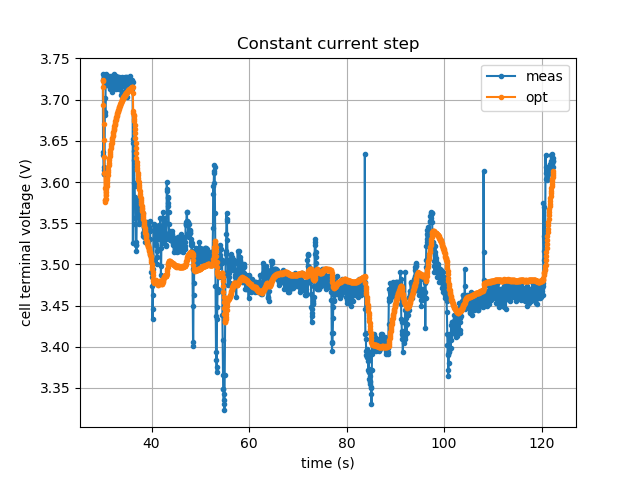

In [20]:
plt.figure()
plt.plot(time,voltage,'.-',label='meas')
plt.plot(time,vsimopt,'.-',label='opt')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('cell terminal voltage (V)')
plt.title('Constant current step')
plt.grid()
plt.show()
